# Cats on That

The contents of this notebook constitute the USD MSAAI Image Processing final project Team 5's appendices submission on 12/12/2022.

Team 5 consists of the following members:


1.   Ian Timmons
2.   Ian Feekes
3.   Jester Ugalde
4.   Yevginiya Okuneva

## Initial Configuration

The following few cells perform initial configuration for the notebook, such as importing libraries, setting global variables, and mounting files and repositories as necessary

### Imports

In [1]:
import keras
import tensorflow as tf
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, MaxPooling2D, Conv2D, BatchNormalization
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from PIL import Image, ImageChops, ImageFilter

# File operations
import os
import os.path
from pathlib import Path
import glob

# Image processing and displaying operations
import cv2

# Dataframe and series operations
import pandas as pd
import numpy as np

# Create callback to limit the number of epochs once learning ceases
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
from keras.utils.vis_utils import plot_model

### Global Variables

In [19]:
# Kaggle Token Path on Google Drive
kaggleTokenPath = '/content/drive/My Drive/Colab Notebooks/Image_Processing/kaggle.json'
datasetDownloadKaggle = True

# Path used for data exploration
GeorgianArchitectureImagesPath = '/content/train/arcDataset/Georgian architecture'
# Path used to contain data
dataDirPath = '/content/train/arcDataset'

### Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configuring & Installing Kaggle

To obtain the architecture dataset, it may be stored locally, however it can also be obtained from Kaggle. To run Kaggle download commands to import datasets, one must first install kaggle via CLI.

In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now that the CLI is installed for Kaggle, all that is needed is an access token. This can be downloaded from the Kaggle Account page and clicking "generate API key" then moving it to a selected part of google drive.

https://www.kaggle.com/general/74235

In [7]:
!kaggle datasets download -d wwymak/architecture-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [8]:
!mkdir ~/.kaggle 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
!cp '/content/drive/My Drive/Colab Notebooks/Image_Processing/kaggle.json' ~/.kaggle/

In [10]:
!chmod 600 ~/.kaggle/kaggle.json

Download the actual dataset

In [11]:
!kaggle datasets download -d wwymak/architecture-dataset

 99% 1.42G/1.43G [00:11<00:00, 139MB/s]
100% 1.43G/1.43G [00:11<00:00, 135MB/s]


Create training directories and extract the downloaded data into the directories

In [12]:
!mkdir '/content/train'

In [13]:
#!unzip train.zip -d train

In [17]:
!unzip /content/architecture-dataset.zip -d /content/train

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/arcDataset/Russian Revival architecture/476_402px-%D0%91%D0%BE%D0%BB%D0%B3%D0%B0%D1%80%D0%B8%D1%8F%2C_%D0%A8%D0%B8%D0%BF%D0%BA%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9_%D0%BF%D0%B5%D1%80%D0%B5%D0%B2%D0%B0%D0%BB.jpg  
  inflating: /content/train/arcDataset/Russian Revival architecture/4840_600px-Cathedral_of_Christ_the_Saviour_3.jpg  
  inflating: /content/train/arcDataset/Russian Revival architecture/4843_561px-Christ_the_Savior_Cathedral_Moscow.jpg  
  inflating: /content/train/arcDataset/Russian Revival architecture/4848_683px-Moscow_July_2011-6a.jpg  
  inflating: /content/train/arcDataset/Russian Revival architecture/4849_800px-Moscow_-_Cathedral_of_Christ_the_Saviour4.jpg  
  inflating: /content/train/arcDataset/Russian Revival architecture/4853_471px-Moscow_-_Cathedral_of_Christ_the_Saviour.jpg  
  inflating: /content/train/arcDataset/Russian Revival architecture/4874_683px-Moscow_July_2011-6a.jpg  
  infla

## EDA and Pre-Processing

Include a clear discussion that ensures all steps are clearly explained and addresses the following:
How did you make sure that you are ready to apply deep learning models?
What type of pre-processing is required on your data?
How can you define and refine various feature variables that you may potentially use for the modeling?
Have additional features added to demonstrate necessary image processing, image preparation, or image access for later AI computation?


In [20]:
# List of file/directory names which do not have data of interest
# These files describe architectural relationships and time frames, which are
#    not currently relevant to our application
badSubDirNames = ['ReadMe~', 'ReadMe', 'arcRelationship25.txt', 'arcNames25.txt',
                  'relationship.txt']

# Get all files in our data directory
subDirNames = os.listdir(dataDirPath)

for name in badSubDirNames:
  subDirNames.remove(name)
  assert(name not in subDirNames)

subDirNames

['Russian Revival architecture',
 'American craftsman style',
 'Georgian architecture',
 'Byzantine architecture',
 'Palladian architecture',
 'Tudor Revival architecture',
 'American Foursquare architecture',
 'Romanesque architecture',
 'Ancient Egyptian architecture',
 'Queen Anne architecture',
 'International style',
 'Art Deco architecture',
 'Chicago school architecture',
 'Bauhaus architecture',
 'Greek Revival architecture',
 'Deconstructivism',
 'Edwardian architecture',
 'Art Nouveau architecture',
 'Gothic architecture',
 'Baroque architecture',
 'Colonial architecture',
 'Achaemenid architecture',
 'Postmodern architecture',
 'Beaux-Arts architecture',
 'Novelty architecture']

In [21]:
# Declare Empty data frame object
MAIN_ARC = pd.DataFrame(dtype = str)

# Go through each directory and pick up all jpg files, appending the directory name as a column to the data frame
for directoryName in subDirNames:
  fullPath = dataDirPath + "/" + directoryName
  # Load files from the dataset
  fileList = list(Path(fullPath).glob(r"*.jpg"))
  # Convert list of file names into a series
  fileImageSeries = pd.Series(fileList, name="directoryName").astype(str)
  MAIN_ARC[directoryName] = fileImageSeries

# Data frame should have a column for each directory and should have many columns
assert(MAIN_ARC.shape[0] > 0 and MAIN_ARC.shape[1] == len(subDirNames))

# Show the first 5 columns of our new data frame object
MAIN_ARC.head(5)

,Russian Revival architecture,American craftsman style,Georgian architecture,Byzantine architecture,Palladian architecture,Tudor Revival architecture,American Foursquare architecture,Romanesque architecture,Ancient Egyptian architecture,Queen Anne architecture,...,Deconstructivism,Edwardian architecture,Art Nouveau architecture,Gothic architecture,Baroque architecture,Colonial architecture,Achaemenid architecture,Postmodern architecture,Beaux-Arts architecture,Novelty architecture
0,/content/train/arcDataset/Russian Revival arch...,/content/train/arcDataset/American craftsman s...,/content/train/arcDataset/Georgian architectur...,/content/train/arcDataset/Byzantine architectu...,/content/train/arcDataset/Palladian architectu...,/content/train/arcDataset/Tudor Revival archit...,/content/train/arcDataset/American Foursquare ...,/content/train/arcDataset/Romanesque architect...,/content/train/arcDataset/Ancient Egyptian arc...,/content/train/arcDataset/Queen Anne architect...,...,/content/train/arcDataset/Deconstructivism/273...,/content/train/arcDataset/Edwardian architectu...,/content/train/arcDataset/Art Nouveau architec...,/content/train/arcDataset/Gothic architecture/...,/content/train/arcDataset/Baroque architecture...,/content/train/arcDataset/Colonial architectur...,/content/train/arcDataset/Achaemenid architect...,/content/train/arcDataset/Postmodern architect...,/content/train/arcDataset/Beaux-Arts architect...,/content/train/arcDataset/Novelty architecture...
1,/content/train/arcDataset/Russian Revival arch...,/content/train/arcDataset/American craftsman s...,/content/train/arcDataset/Georgian architectur...,/content/train/arcDataset/Byzantine architectu...,/content/train/arcDataset/Palladian architectu...,/content/train/arcDataset/Tudor Revival archit...,/content/train/arcDataset/American Foursquare ...,/content/train/arcDataset/Romanesque architect...,/content/train/arcDataset/Ancient Egyptian arc...,/content/train/arcDataset/Queen Anne architect...,...,/content/train/arcDataset/Deconstructivism/580...,/content/train/arcDataset/Edwardian architectu...,/content/train/arcDataset/Art Nouveau architec...,/content/train/arcDataset/Gothic architecture/...,/content/train/arcDataset/Baroque architecture...,/content/train/arcDataset/Colonial architectur...,/content/train/arcDataset/Achaemenid architect...,/content/train/arcDataset/Postmodern architect...,/content/train/arcDataset/Beaux-Arts architect...,/content/train/arcDataset/Novelty architecture...
2,/content/train/arcDataset/Russian Revival arch...,/content/train/arcDataset/American craftsman s...,/content/train/arcDataset/Georgian architectur...,/content/train/arcDataset/Byzantine architectu...,/content/train/arcDataset/Palladian architectu...,/content/train/arcDataset/Tudor Revival archit...,/content/train/arcDataset/American Foursquare ...,/content/train/arcDataset/Romanesque architect...,/content/train/arcDataset/Ancient Egyptian arc...,/content/train/arcDataset/Queen Anne architect...,...,/content/train/arcDataset/Deconstructivism/240...,/content/train/arcDataset/Edwardian architectu...,/content/train/arcDataset/Art Nouveau architec...,/content/train/arcDataset/Gothic architecture/...,/content/train/arcDataset/Baroque architecture...,/content/train/arcDataset/Colonial architectur...,/content/train/arcDataset/Achaemenid architect...,/content/train/arcDataset/Postmodern architect...,/content/train/arcDataset/Beaux-Arts architect...,/content/train/arcDataset/Novelty architecture...
3,/content/train/arcDataset/Russian Revival arch...,/content/train/arcDataset/American craftsman s...,/content/train/arcDataset/Georgian architectur...,/content/train/arcDataset/Byzantine architectu...,/content/train/arcDataset/Palladian architectu...,/content/train/arcDataset/Tudor Revival archit...,/content/train/arcDataset/American Foursquare ...,/content/train/arcDataset/Romanesque architect...,/content/train/arcDataset/Ancient Egyptian arc...,/content/train/arcDataset/Queen Anne archite

In [22]:
numColumns = 0
for col in MAIN_ARC.columns:
  numColumns = numColumns + len(col)

print(numColumns)

574


Dropping bad entries

We can see from the following cell that the images are not all of equal dimensions and will need to be resized and normalized

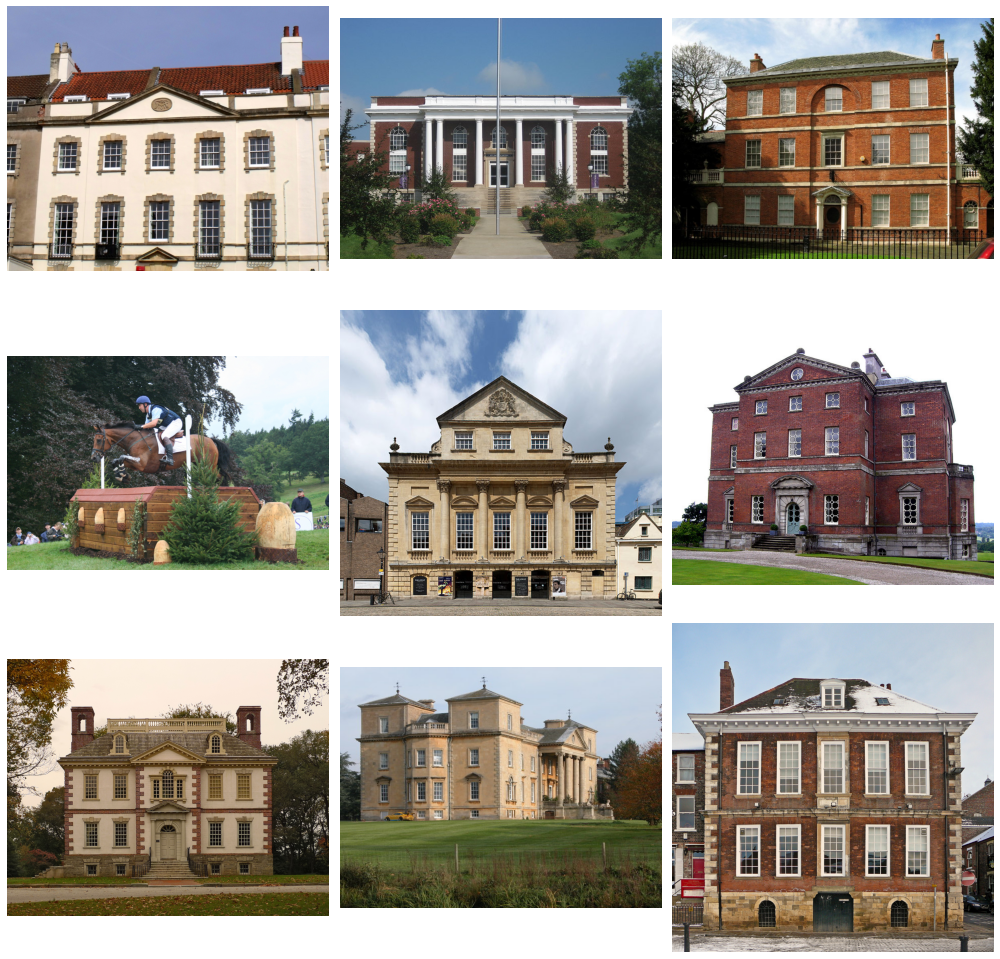


The number of different widths for the first 9 images is: 8
The number of different heights for the first 9 images is: 7


In [23]:
# Declare lists to illustrate the different widths and heights in the images
differentWidths = []
differentHeights = []

figure,axis = plt.subplots(3,3,figsize=(14,14))

for i_ind,i_ops in enumerate(axis.flat):
    # Process current frame as opencv structure and convert the proper color format
    IMAGE_READING = cv2.cvtColor(cv2.imread(MAIN_ARC[MAIN_ARC.columns[2]][i_ind]),cv2.COLOR_BGR2RGB)
    # Append dimensions to the array list for data analysis - all images should be rgb
    if IMAGE_READING.shape[0] not in differentHeights:
      differentHeights.append(IMAGE_READING.shape[0])
    if IMAGE_READING.shape[1] not in differentWidths:
      differentWidths.append(IMAGE_READING.shape[1])
    i_ops.axis("off")
    i_ops.imshow(IMAGE_READING)
    
plt.tight_layout()
plt.show()    

# Show that the images have different dimensions and will need to be resized
print()
print("The number of different widths for the first 9 images is:", len(differentWidths))
print("The number of different heights for the first 9 images is:", len(differentHeights))

#### Analyzing Architecture Image Dimensions

In [24]:
# Declare a variable to be the smallest image shape
smallestImageShape = cv2.imread(MAIN_ARC[MAIN_ARC.columns[1]][0]).shape
# Get the width and height
smallestX = smallestImageShape[0]
smallestY = smallestImageShape[1]
# Iterate through data frame and determine the largest possible resolution we can resize to
for col in MAIN_ARC.columns:
  for row in MAIN_ARC[col]:
    # Data frame organization will break for directories of differing numbers of files
    if row != 'nan' and type(row) == str:
      image = cv2.imread(row)
      if image.shape[0] < smallestX:
        smallestX = image.shape[0]
      if image.shape[1] < smallestY:
        smallestY = image.shape[1]

smallestImageShape = (smallestX, smallestY)
smallestImageShape

(80, 127)

The smallest dimensions that would fit any given image 80 x 127 is a bit small and a lot of valuable data would be lost from most of the images if one were to resize all images to this size.

As such it may be pertinent to drop images below a certain width threshold, since there are plenty of images in the entire architecture dataset, and particular pieces of architecture are only of consequence in the sense that "gaps" in the architecture where cats would be inserted may appear differently.

In [45]:
xDimensions = {}
yDimensions = {}

for col in MAIN_ARC.columns:
  for row in MAIN_ARC[col]:
    if row != 'nan' and type(row) == str:
      image = cv2.imread(row)
      # Increment frequency of width
      if image.shape[0] not in xDimensions.keys():
        xDimensions[image.shape[0]] = 1
      else:
        xDimensions[image.shape[0]] = xDimensions[image.shape[0]] + 1
      # Increment frequency of height
      if image.shape[1] not in yDimensions.keys():
        yDimensions[image.shape[1]] = 1
      else:
        yDimensions[image.shape[1]] = yDimensions[image.shape[1]] + 1

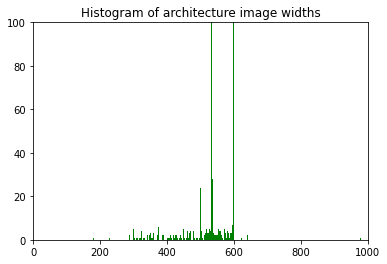

In [38]:
plt.bar(xDimensions.keys(), xDimensions.values(), 1.0, color='g')
plt.ylim([0, 100])
plt.xlim([0, 1000])
plt.title("Histogram of architecture image widths")
plt.show()

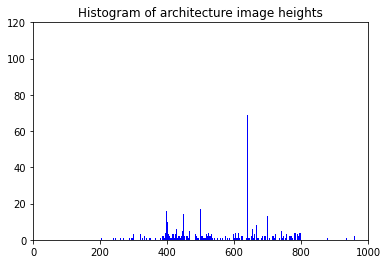

In [44]:
plt.bar(yDimensions.keys(), yDimensions.values(), 1.0, color='b')
plt.ylim([0, 120])
plt.xlim([0, 1000])
plt.title("Histogram of architecture image heights")
plt.show()

One can see from the above plots (which both have some outliers cut off) that there is some noteworthy variation in the image dimensions.

For image widths, the vast majority of images are between 400 and 600px.

For image heights, there is greater variance, but most images are between 400 and 800px. 

So resizing images to a width of 400 may allow retaining the most value in keeping the majority of the dataset and image sizes. Thresholding may be useful outside the bounds above so that the model does not get any bias from minified architecture pixels in the kernel.

#### Thresholding Architecture Image Dimensions

In [50]:
widthBounds = (400, 600)
heightBounds = (400, 800)

images = []

for col in MAIN_ARC.columns:
  for row in MAIN_ARC[col]:
    if row != 'nan' and type(row) == str:
      image = cv2.imread(row)
      if ((widthBounds[0] <= image.shape[0] and image.shape[0] <= widthBounds[1])
         and (heightBounds[0] <= image.shape[1] and image.shape[1] <= heightBounds[1])):
        images.append(image)

## Modeling Methods, Validation, and Performance Metrics

Perform modeling using the training dataset.
Evaluate the model(s) using the test dataset and validate as well.
Ensure all modeling methods are well-motivated, correctly implemented, and, to the extent appropriate, span the range of methods discussed in this course.
Cross-validation and/or held-out test sets are used in accordance with best practices to assess model performance.
Performance metrics are carefully tailored to the project objectives.


## Modeling Results and Findings

Discuss the results comparing different models and explain the differences and the challenges.
Ensure all project objectives are fully met, findings are clearly presented, and question(s) are technically addressed in the report.
Include tables/graphs comparing the different models, including their characteristics, performance, and accuracy.